# Configuración

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

#Plot Config
plt.rcParams["figure.figsize"] = (12, 6)

#Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

A continuación se tienen los métodos a utilizar en estos experimentos:

In [ ]:
def REKB(A, B, X0=None, max_iter=None, tol=1e-8):
  r, m = A.shape
  _, n = B.shape
  max_iter = max_iter if max_iter is not None else  100000 * max(m, n)
  X = X0 if X0 is not None else torch.zeros((m,n), dtype=A.dtype, device=A.device)
  Xold = X
  Z = B.clone()

  A_frob = torch.norm(A, p='fro')**2
  probs_p = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])
  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])

  for k in range(max_iter):
    i = torch.multinomial(probs_p, 1)[0]
    j = torch.multinomial(probs_q, 1)[0]

    a_i = A[i]
    a_j = A[:, j]

    Z -= (a_j[:, None] / torch.sum(a_j**2)) @ (a_j @ Z)[None, :]
    Xold = X.clone()
    X += (a_i[:, None] / torch.sum(a_i**2)) @ (B[i] - Z[i] - torch.matmul(a_i, X))[None, :]

    if torch.norm(B - A @ X)/torch.norm(B) < tol:
      return X, k + 1

    if k % 1000 == 0:
      if torch.linalg.norm(X - Xold)/torch.linalg.norm(Xold) < 10e-12:
        return X, k + 1

  return X, max_iter

In [ ]:
import torch
import matplotlib.pyplot as plt

def CGC(A, b, x0=None, max_iter=1e8, tol=1e-8):
    m, n = A.shape
    device = A.device
    dtype = A.dtype

    x = x0 if x0 is not None else torch.ones(n, dtype=dtype, device=device)

    # Re-use computations
    Ax = torch.matmul(A, x)
    a_norms = torch.linalg.norm(A, ord=2, dim=1)**2

    # 1. Obtain points ci beloging to the hyperplanes by proyecting the vector x0 on them
    C = x - ((Ax - b)[:, None] * A / a_norms[:, None])

    # 2. Obtain the sum of the orthogonal proyections to all the hyperplanes of the points ci
    b = torch.matmul(A.T, torch.einsum('ij,ji->i', A, C.T) / a_norms)

    # Initialization of GC variables
    Ax = torch.matmul(Ax / a_norms, A)
    r = b - Ax
    p = r
    v = torch.dot(r, r)

    A = A.T @ (A / a_norms[:, None]) #Substitute Matrix A to free space
    # CG Loop
    for k in range(max_iter):
        h = A @ p
        u = torch.dot(p, h)

        alpha = v / u
        x += alpha * p
        r -= alpha * h
        v_next = torch.dot(r, r)

        if torch.sqrt(v_next) < tol:
            return x, k + 1

        beta = v_next / v
        p = r + beta * p
        v = v_next

    return x, max_iter

In [ ]:
def CGCB(A, B, X0=None, max_iter=10000, tol=1e-6):
  m, n = A.shape
  m, p = B.shape
  X = X0 if X0 is not None else torch.ones((n, p), dtype=A.dtype, device=A.device).to(device)

  # Re-use computations
  AX = torch.matmul(A, X)
  a_norms = torch.linalg.norm(A, ord=2, dim=1)**2

  # For each LPS problem
  proyB = torch.zeros((n, p), device=device)
  scaledA = A / a_norms[:, None]

  for i in range(p):
    # 1. Obtain points ci beloging to the hyperplanes by proyecting the vector x0 on them for each f
    C = X[:, i] - ((AX[: , i] - B[:, i])[:, None] * scaledA)
    # 2. Obtain the sum of the orthogonal proyections to all the hyperplanes of the points ci
    proyB[:, i] =  torch.matmul(scaledA.T, torch.sum(A * C, dim=1))
  B = proyB

  # Initialization of GC variables
  AX = torch.matmul(scaledA.T, AX)
  R = B - AX      # Residual
  P = R.clone()   # Search direction
  R_old = R.T @ R

  A = A.T @ scaledA #Substitute Matrix A to free space
  for iter_count in range(max_iter):
      H = A @ P
      Ak = torch.linalg.pinv(P.T @ H) @ R_old    # Step size matrix
      X += P @ Ak
      R -= H @ Ak

      res = torch.max(torch.linalg.norm(R,axis=0))
      if res <= tol:
            break

      RTR = R.T @ R
      Phi =  torch.linalg.pinv(R_old) @ RTR
      P = R + P @ Phi
      R_old = RTR

  return X, iter_count

In [ ]:
def RBFNN_predict(X, W, C, sigmas):
  # Get Distances
  B = torch.mm(X, C)
  D = ((X**2).sum(1).unsqueeze(1).expand_as(B) + (C**2).sum(0).expand_as(B) - 2.0 * B).to(device)

  # Apply Kernel
  gamma = torch.exp(torch.Tensor([1])).to(device)
  sigmas_reshaped = torch.tensor(sigmas, device=device).unsqueeze(0)
  E = torch.exp(- D / (2 * sigmas_reshaped**2))

  # Make Prediction
  num_classes = W.shape[0]
  y_pred = []
  yi = W[:, 0].unsqueeze(0) + torch.matmul(E, W[:, 1:].T)
  labels = torch.argmax(yi, dim=1)
  y_pred = labels.tolist()

  return y_pred

def gaussian(A, sigmas, eps=1):
  sigmas = torch.tensor(sigmas, device=device).unsqueeze(0)
  return torch.exp(-(eps*A)**2/(2*sigmas**2))

def radial_base(A, centers, sigmas, rbf=gaussian):
  distances = torch.cdist(A, centers,  p=2)
  return rbf(distances, sigmas)

def r(distances, sigmas, w, rbf=gaussian):
  return w[0] + torch.sum(w[1:] * rbf(distances, sigmas))

# MNIST

In [ ]:
from keras.datasets import mnist
import torch
import math
from torch.nn.functional import one_hot
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from collections import defaultdict
import time

# Cargar datos
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshapes
X_train = X_train.reshape(len(X_train), -1)/255.0
X_test = X_test.reshape(len(X_test), -1)/255.0

# Get centers
t1 = time.time()
n_centers = int(math.sqrt(X_train.shape[0]) + 1) + 800
print(n_centers)
kmeans = MiniBatchKMeans(n_clusters=n_centers, random_state=0, n_init="auto")
distances = kmeans.fit_transform(X_train)
labels = kmeans.labels_

cluster_counts = np.bincount(labels)
cluster_sums = np.zeros(n_centers)
for i, label in enumerate(labels):
    cluster_sums[label] += distances[i, label]

average_distances = {label: cluster_sums[label] / cluster_counts[label] for label in range(n_centers)}
centers = torch.from_numpy(kmeans.cluster_centers_).to(device)
sigmas = np.array(list(average_distances.values()))

# Convertir arreglos a tensores de Pytorch
X_train = torch.tensor(X_train, dtype=torch.double, device=device)
y_train = torch.tensor(y_train, dtype=torch.int64, device=device)
X_test = torch.tensor(X_test, dtype=torch.double, device=device)
#y_test = torch.tensor(y_test, dtype=torch.int64, device=device)

y_train_encoded = one_hot(y_train,10)

print(n_centers)
print("X train tensor shape:", X_train.shape)
print("X test tensor shape:", y_train.shape)

ones_tensor = torch.ones(X_train.shape[0], 1, device=device)
A = radial_base(X_train, centers, sigmas)
A = torch.cat(( ones_tensor, A), dim=1)
t2 = time.time()
print(t2-t1)

print(np.linalg.cond(A.cpu().numpy()))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1045
1045
X train tensor shape: torch.Size([60000, 784])
X test tensor shape: torch.Size([60000])
23.233525037765503
6029.289614882005


Entrenamiento con CGC por bloques:

In [ ]:
import time

times = []
n=30
for i in range(n):
  t1 = time.time()
  W, iter = CGCB(A, B=y_train_encoded, max_iter=20000)
  t2 = time.time()
  times.append(t2-t1)
print(sum(times)/n)

3.9947097937266034


Entrenamiento con mínimos cuadrados de Pytorch:

In [ ]:
import time

times = []
n=30
for i in range(n):
  t1 = time.time()
  W = torch.linalg.lstsq(A, y_train_encoded.double()).solution
  t2 = time.time()
  times.append(t2-t1)
print(sum(times)/n)

Entrenamiento con entrenamiento 1 clase a la vez con CGC:

In [ ]:
times = []
n=30
for i in range(n):
  t1 = time.time()
  weights = []
  for i in range(10):
    b = y_train_encoded[:, i].clone().detach()

    w, iter = CGC(A, b, max_iter=2000)
    weights.append(w)
  W = torch.stack(weights, dim=0)
  t2 = time.time()
  times.append(t2-t1)
print(sum(times)/n)

3.1040705998738605


In [ ]:
y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

MNIST Train Accuracy: 96.87%


In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)

correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

MNIST Test Accuracy: 96.67%


### Prueba de Aprendizaje Incremental con REK

In [ ]:
def solveREKB(A, B, X0=None, max_iter=None, tol=1e-7):
  W = []
  iterTotal = 0
  for i in range(10):
    b = B[:, i].clone().detach()
    w, iter = extended_random_kacmarz(A, b, max_iter=2000)
    W.append(w)
    iterTotal += iter
  W = torch.stack(W, dim=0).T
  print(W.shape)
  print(iterTotal)
  return W, iterTotal

In [ ]:
import time

t1 = time.time()
W, itertotal = solveREKB(A[:1000, :], B=y_train_encoded[:1000, :].double())
t2 = time.time()
print(t2-t1)

y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

torch.Size([246, 10])
20000
14.4942467212677
MNIST Train Accuracy: 78.68%
MNIST Test Accuracy: 78.94%


In [ ]:
t1 = time.time()
W, iter = REKB(A[:5000, :], B=y_train_encoded[:5000, :].double(), max_iter=1000000)
print(iter)
t2 = time.time()
print(t2-t1)

y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

1000000
2131.1559484004974
MNIST Train Accuracy: 93.15%
MNIST Test Accuracy: 93.22%


In [ ]:
t1 = time.time()
W2, iter = REKB(A, B=y_train_encoded.double(), X0=W, max_iter=100000)
print(iter)
t2 = time.time()
print(t2-t1)

y_pred = RBFNN_predict(X=X_train, W=W2.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W2.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

100000
3096.6811633110046
MNIST Train Accuracy: 92.55%
MNIST Test Accuracy: 93.00%


In [ ]:
t1 = time.time()
W2, iter = REKB(A, B=y_train_encoded.double(), max_iter=100000)
print(iter)
t2 = time.time()
print(t2-t1)

y_pred = RBFNN_predict(X=X_train, W=W2.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W2.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

In [ ]:
t1 = time.time()
W3, iter = CGCB(A[2000:3000, :], B=y_train_encoded[2000:3000, :], max_iter=20000)
print(iter)
t2 = time.time()
print(t2-t1)

W += W3 / 2

y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

131
0.07279229164123535
MNIST Train Accuracy: 93.05%
MNIST Test Accuracy: 93.27%


In [ ]:
import time

t1 = time.time()
W = torch.linalg.lstsq(A[:1000, :], y_train_encoded[:1000, :].double()).solution
t2 = time.time()
print(t2-t1)

y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

0.01929187774658203
MNIST Train Accuracy: 91.18%
MNIST Test Accuracy: 91.51%


In [ ]:
t1 = time.time()
W2 = torch.linalg.lstsq(A[1000:2000, :], y_train_encoded[1000:2000, :].double()).solution
t2 = time.time()
print(t2-t1)

W += W2 / 2

y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

0.00990152359008789
MNIST Train Accuracy: 92.47%
MNIST Test Accuracy: 92.87%


In [ ]:
t1 = time.time()
W3 = torch.linalg.lstsq(A[3000:4000, :], y_train_encoded[3000:4000, :].double()).solution
t2 = time.time()
print(t2-t1)

W += W3 / 2

y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

0.01771259307861328
MNIST Train Accuracy: 93.01%
MNIST Test Accuracy: 93.32%


### KC-CG-Cimmino

In [ ]:
import time

t1 = time.time()

batch_size =  32768
weights = []
num_rows = A.shape[0]
print(A.shape)

iter_weights = []
for _ in range(num_rows // batch_size + (1 if num_rows % batch_size else 0)): #iterate over the batches.
    # Randomly select batch indices
    indices = np.random.choice(num_rows, size=min(batch_size, num_rows), replace=False)
    A_batch = A[indices, :]
    b_batch = y_train_encoded[indices]

    W, iter_count = CGCB(A=A_batch, B=b_batch, max_iter=2000)
    print(iter_count)
    iter_weights.append(W)

    #reduce the number of rows left to choose from.
    num_rows = num_rows - len(indices)
    if num_rows <= 0:
      break

# Average weights from batches
stacked_weights = torch.stack(iter_weights)
W = torch.mean(stacked_weights, dim=0)

t2 = time.time()
print(t2-t1)

torch.Size([60000, 246])
119
119
0.9498007297515869


In [ ]:
y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"MNIST Train Accuracy: {accuracy :.2f}%")

MNIST Train Accuracy: 94.01%


In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)

correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"MNIST Test Accuracy: {accuracy :.2f}%")

MNIST Test Accuracy: 94.07%


# Fashion MNIST

In [ ]:
from keras.datasets import mnist
from torch.nn.functional import one_hot
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from collections import defaultdict
from torchvision import datasets, transforms

t1 = time.time()

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

X_train_np = trainset.data.reshape(len(trainset.data), -1)/255.0
X_test = testset.data.reshape(len(testset.data), -1)/255.0

X_train = torch.tensor(X_train_np, dtype=torch.double, device=device)
X_test = torch.tensor(X_test, dtype=torch.double, device=device)

y_train = torch.tensor(trainset.targets, dtype=torch.int64, device=device)
y_test = torch.tensor(testset.targets, dtype=torch.int64, device=device)
y_train_encoded = one_hot(y_train, 10).double()

# Get centers
n_centers = int(math.sqrt(X_train.shape[0]) + 1)
print(n_centers)
kmeans = MiniBatchKMeans(n_clusters=n_centers, random_state=0, n_init="auto")
distances = kmeans.fit_transform(X_train_np)
labels = kmeans.labels_

cluster_counts = np.bincount(labels)
cluster_sums = np.zeros(n_centers)
for i, label in enumerate(labels):
    cluster_sums[label] += distances[i, label]

average_distances = {label: cluster_sums[label] / cluster_counts[label] for label in range(n_centers)}
centers = torch.from_numpy(kmeans.cluster_centers_).to(device)
sigmas = np.array(list(average_distances.values()))

ones_tensor = torch.ones(X_train.shape[0], 1, device=device)
A = radial_base(X_train, centers, sigmas)
A = torch.cat((ones_tensor, A), dim=1)

t2 = time.time()

print(t2-t1)

print(np.linalg.cond(A.cpu().numpy()))

<ipython-input-11-b4bcef0d3014>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train_np, dtype=torch.double, device=device)
<ipython-input-11-b4bcef0d3014>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.double, device=device)
<ipython-input-11-b4bcef0d3014>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(trainset.targets, dtype=torch.int64, device=device)
<ipython-input-11-b4bcef0d3014>:26: UserWarning: To copy construct from a tensor, it is 

245
9.048364639282227
1486.6818645780534


In [ ]:
import time

times = []
n=30
for i in range(n):
  t1 = time.time()
  weights = []
  for i in range(10):
    b = y_train_encoded[:, i].clone().detach()

    w, iter = CGC(A, b, max_iter=2000)
    weights.append(w)
  W = torch.stack(weights, dim=0)
  t2 = time.time()
  times.append(t2-t1)
print(sum(times)/n)

3.8430747270584105


In [ ]:
batch_size =  16384
weights = []
num_rows = A.shape[0]

import time

t1 = time.time()
print(A.shape)

iter_weights = []
for _ in range(num_rows // batch_size + (1 if num_rows % batch_size else 0)): #iterate over the batches.
    # Randomly select batch indices
    indices = np.random.choice(num_rows, size=min(batch_size, num_rows), replace=False)
    A_batch = A[indices, :]
    b_batch = y_train_encoded[indices]

    W, iter_count = CGCB(A=A_batch, B=b_batch, max_iter=2000)
    iter_weights.append(W)

    #reduce the number of rows left to choose from.
    num_rows = num_rows - len(indices)
    if num_rows <= 0:
      break

# Average weights from batches
stacked_weights = torch.stack(iter_weights)
W = torch.mean(stacked_weights, dim=0)

t2 = time.time()
print(t2-t1)

torch.Size([60000, 246])
1.3518917560577393


In [ ]:
y_pred = RBFNN_predict(X=X_train, W=W, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"Fashion MNIST train Accuracy: {accuracy :.2f}%")

Fashion MNIST train Accuracy: 84.25%


In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test.cpu().numpy())
total = len(y_test)
accuracy = (correct / total) * 100
print(f"Fashion MNIST test Accuracy: {accuracy :.2f}%")

Fashion MNIST test Accuracy: 83.20%


In [ ]:
x = torch.tensor([[3], [2]], dtype=torch.double, device=device)
y = torch.tensor([[1, 7], [2, 3]], dtype=torch.double, device=device)
torch.sum(y, dim=1)

tensor([8., 5.], dtype=torch.float64)

In [ ]:
x = torch.tensor([3, 2], dtype=torch.double, device=device)
print(x)
y = torch.tensor([[1, 2], [2, 3], [6, 3]], dtype=torch.double, device=device)
print(y)
print(x.shape, y.shape)
x - y

tensor([3., 2.], dtype=torch.float64)
tensor([[1., 2.],
        [2., 3.],
        [6., 3.]], dtype=torch.float64)
torch.Size([2]) torch.Size([3, 2])


tensor([[ 2.,  0.],
        [ 1., -1.],
        [-3., -1.]], dtype=torch.float64)

In [ ]:
import time


times = []
n=30
for i in range(n):
  t1 = time.time()
  W, iter = CGCB(A, B=y_train_encoded, max_iter=20000)
  t2 = time.time()
  times.append(t2-t1)
print(sum(times)/n)

0.4262925386428833


In [ ]:
t1 = time.time()
W = torch.linalg.lstsq(A, y_train_encoded.double()).solution
t2 = time.time()
print(t2-t1)

0.33359599113464355


In [ ]:
y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"Fashion MNIST train Accuracy: {accuracy :.2f}%")

Fashion MNIST train Accuracy: 84.25%


In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test.cpu().numpy())
total = len(y_test)
accuracy = (correct / total) * 100
print(f"Fashion MNIST test Accuracy: {accuracy :.2f}%")

Fashion MNIST test Accuracy: 83.20%


# KMINST


In [ ]:
from torchvision import datasets, transforms
import torch
import math
from torch.nn.functional import one_hot
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from collections import defaultdict

t1 = time.time()

# Define a transform to normalize the data (optional, but often beneficial)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust mean and std as needed
])

# Load the Kuzushiji-MNIST dataset
trainset = datasets.KMNIST('data', train=True, download=True, transform=transform)
testset = datasets.KMNIST('data', train=False, download=True, transform=transform)

# Extract data and labels
X_train = trainset.data.numpy().reshape(len(trainset.data), -1) / 255.0
X_test = testset.data.numpy().reshape(len(testset.data), -1) / 255.0
y_train = trainset.targets.numpy()
y_test = testset.targets.numpy()

print(X_test.shape, len(y_test))

# Get centers
n_centers = int(math.sqrt(X_train.shape[0]) + 1) + 100
print(n_centers)
kmeans = MiniBatchKMeans(n_clusters=n_centers, random_state=0, n_init="auto")
distances = kmeans.fit_transform(X_train)
labels = kmeans.labels_

cluster_counts = np.bincount(labels)
cluster_sums = np.zeros(n_centers)
for i, label in enumerate(labels):
    cluster_sums[label] += distances[i, label]

average_distances = {label: cluster_sums[label] / cluster_counts[label] for label in range(n_centers)}
centers = torch.from_numpy(kmeans.cluster_centers_).to(device)
sigmas = np.array(list(average_distances.values()))

# Convert arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.double, device=device)
y_train = torch.tensor(y_train, dtype=torch.int64, device=device)
print(X_test.shape, len(y_test))
X_test = torch.tensor(X_test, dtype=torch.double, device=device)
print(X_test.shape, len(y_test))
# y_test = torch.tensor(y_test, dtype=torch.int64, device=device)  # Uncomment if needed

y_train_encoded = one_hot(y_train, 10)  # 10 classes in Kuzushiji-MNIST

print(n_centers)
print("X train tensor shape:", X_train.shape)
print("X test tensor shape:", y_train.shape)  # Should be X_test.shape?

ones_tensor = torch.ones(X_train.shape[0], 1, device=device)
A = radial_base(X_train, centers, sigmas)  # Assuming radial_base is defined
A = torch.cat((ones_tensor, A), dim=1)

t2 = time.time()

print(t2-t1)

print(np.linalg.cond(A.cpu().numpy()))

100%|██████████| 18.2M/18.2M [00:13<00:00, 1.38MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 278kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.29MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 14.9MB/s]


(10000, 784) 10000
345
(10000, 784) 10000
torch.Size([10000, 784]) 10000
345
X train tensor shape: torch.Size([60000, 784])
X test tensor shape: torch.Size([60000])
27.894587516784668
4240.306819277804


In [ ]:
import time

times = []
n=30
for i in range(n):
  t1 = time.time()
  weights = []
  for i in range(10):
    b = y_train_encoded[:, i].clone().detach()

    w, iter = CGC(A, b, max_iter=2000)
    weights.append(w)
  W = torch.stack(weights, dim=0).T
  t2 = time.time()
  times.append(t2-t1)
print(sum(times)/n)

4.5895832777023315


In [ ]:
import time
times = []
n=30
for i in range(n):
  t1 = time.time()
  W, iter = CGCB(A, B=y_train_encoded, max_iter=20000)
  t2 = time.time()
  times.append(t2-t1)
print(sum(times)/n)

1.632402205467224


In [ ]:
import time

t1 = time.time()
W = torch.linalg.lstsq(A, y_train_encoded.double()).solution
t2 = time.time()
print(t2-t1)
print(W.shape)

0.26362061500549316
torch.Size([346, 10])


In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
balanced_accuracy = balanced_accuracy_score(y_train.cpu().numpy(), y_pred) * 100
print(f"KMINST train Balanced Accuracy: {balanced_accuracy:.2f}%")

KMINST train Balanced Accuracy: 90.98%


In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
print(len(y_pred), len(y_test))
balanced_accuracy = balanced_accuracy_score(y_test, y_pred) * 100
print(f"KMINST train Balanced Accuracy: {balanced_accuracy:.2f}%")

10000 10000
KMINST train Balanced Accuracy: 79.68%


In [ ]:
y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"KMINST train Accuracy: {accuracy :.2f}%")

KMINST train Accuracy: 10.00%


In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test)
total = len(y_test)
accuracy = (correct / total) * 100
print(f"KMINST test Accuracy: {accuracy :.2f}%")

KMINST test Accuracy: 77.08%


# Imbalance

# LFW People

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from collections import defaultdict
from sklearn.datasets import fetch_lfw_people
import torch
import math
from sklearn.model_selection import train_test_split

# Load the LFW People dataset
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

# Split data into training and testing sets using train_test_split
X_train_np, X_test_np, y_train, y_test = train_test_split(
    lfw_people.data / 255.0, lfw_people.target, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float, device=device)
y_train = torch.tensor(y_train, dtype=torch.int64, device=device)
y_test = torch.tensor(y_test, dtype=torch.int64, device=device)

# One-hot encode the labels (optional, depending on your use case)
y_train_encoded = one_hot(y_train, len(lfw_people.target_names)).float()

# Get centers (using only the training data)
n_centers = int(math.sqrt(X_train.shape[0]) + 1) + 100
kmeans = MiniBatchKMeans(n_clusters=n_centers, random_state=0, n_init="auto")
distances = kmeans.fit_transform(X_train_np)
labels = kmeans.labels_

cluster_counts = np.bincount(labels)
cluster_sums = np.zeros(n_centers)
for i, label in enumerate(labels):
    cluster_sums[label] += distances[i, label]

average_distances = {label: cluster_sums[label] / cluster_counts[label] for label in range(n_centers)}
centers = torch.from_numpy(kmeans.cluster_centers_).to(device)
sigmas = np.array(list(average_distances.values()))

# Create A matrices for both train and test data
ones_tensor_train = torch.ones(X_train.shape[0], 1, device=device)
A = radial_base(X_train, centers, sigmas)  # Assuming radial_base is defined
A = torch.cat((ones_tensor_train, A), dim=1)

print(A.shape, y_train_encoded.shape)

torch.Size([1248, 625]) torch.Size([1248, 12])


<ipython-input-101-7362211ad211>:37: RuntimeWarning: invalid value encountered in scalar divide
  average_distances = {label: cluster_sums[label] / cluster_counts[label] for label in range(n_centers)}


In [ ]:
import time

t1 = time.time()
W = torch.linalg.lstsq(A, y_train_encoded.double()).solution
t2 = time.time()
print(t2-t1)
print(W.shape)

0.0428614616394043
torch.Size([625, 12])


In [ ]:
y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"LFW train Accuracy: {accuracy :.2f}%")

LFW train Accuracy: 5.29%


In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test.cpu().numpy())
total = len(y_test)
accuracy = (correct / total) * 100
print(f"LFW test Accuracy: {accuracy :.2f}%")

LFW test Accuracy: 3.53%


# CIFAR-10

In [ ]:
from keras.datasets import mnist
from torch.nn.functional import one_hot
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from collections import defaultdict
from torchvision import datasets, transforms

# Download and load the training data
trainset= datasets.CIFAR10('data', train=True, download=True)
testset= datasets.CIFAR10('data', train=False, download=True)

100%|██████████| 170M/170M [00:07<00:00, 22.8MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
X_train_np = trainset.data.reshape(len(trainset.data), -1)
X_test = testset.data.reshape(len(testset.data), -1)

# Convert pixel values data type to float32
X_train = X_train_np.astype('double')
X_test  = X_test.astype('double')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train_np = (X_train_np-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)

X_train = torch.tensor(X_train_np, dtype=torch.double, device=device)
X_test = torch.tensor(X_test, dtype=torch.double, device=device)


y_train = torch.tensor(trainset.targets, dtype=torch.int64, device=device)
y_test = torch.tensor(testset.targets, dtype=torch.int64, device=device)
y_train_encoded = one_hot(y_train, 10).double()

In [ ]:
# Get centers
n_centers = int(X_train.shape[0] / 2)
kmeans = MiniBatchKMeans(n_clusters=n_centers, random_state=0, n_init="auto")
distances = kmeans.fit_transform(X_train_np)
labels = kmeans.labels_

print(n_centers)

cluster_counts = np.bincount(labels)
cluster_sums = np.zeros(n_centers)
for i, label in enumerate(labels):
    cluster_sums[label] += distances[i, label]

average_distances = {label: cluster_sums[label] / cluster_counts[label] for label in range(n_centers)}
centers = torch.from_numpy(kmeans.cluster_centers_).to(device)
sigmas = np.array(list(average_distances.values()))

ones_tensor = torch.ones(X_train.shape[0], 1, device=device)
A = radial_base(X_train, centers, sigmas)
A = torch.cat((ones_tensor, A), dim=1)

KeyboardInterrupt: 

In [ ]:
import time

t1 = time.time()
W = torch.linalg.lstsq(A, y_train_encoded.double()).solution
t2 = time.time()
print(t2-t1)
print(W.shape)

2.865109443664551
torch.Size([2001, 10])


In [ ]:
y_pred = RBFNN_predict(X=X_train, W=W.T, C=centers.T, sigmas=sigmas)
print(y_pred)
print(y_train)
correct = np.sum(y_pred == y_train.cpu().numpy())
total = len(y_train)
accuracy = (correct / total) * 100
print(f"CIFAR-10 Train Accuracy: {accuracy :.2f}%")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
y_pred = RBFNN_predict(X=X_test, W=W.T, C=centers.T, sigmas=sigmas)
correct = np.sum(y_pred == y_test.cpu().numpy())
total = len(y_test)
accuracy = (correct / total) * 100
print(f"CIFAR-10 test Accuracy: {accuracy :.2f}%")

## IDK

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class RAN:
    # ... (RAN class implementation from previous response) ...
    def __init__(self, input_dim, sigma=1.0, threshold=0.9):
        """
        Initializes the RAN.

        Args:
            input_dim: Dimensionality of the input vectors.
            sigma: Width of the Gaussian radial basis functions.
            threshold: Similarity threshold for creating new neurons.
        """
        self.input_dim = input_dim
        self.sigma = sigma
        self.threshold = threshold
        self.centers = []
        self.weights = np.array([])
        self.labels = [] # store the label of each neuron

    def train(self, x, target_label):
        """
        Trains the RAN with a single input-target pair using least squares.

        Args:
            x: Input vector.
            target_label: Target label.
        """
        if not self.centers:
            self.centers.append(x)
            self.weights = np.array([1]) #initial weight
            self.labels.append(target_label)
            return

        activations = np.array([self._gaussian_rbf(x, center) for center in self.centers])

        if max(activations) < self.threshold:
            self.centers.append(x)
            self.weights = np.append(self.weights, 1) #initial weight
            self.labels.append(target_label)
        else:
            self._update_weights_least_squares(x, target_label)

    def _update_weights_least_squares(self, x, target_label):
        phi = np.array([[self._gaussian_rbf(center, input_x) for center in self.centers] for input_x in self.centers])
        t = np.array([1 if self.labels[i] == target_label else 0 for i in range(len(self.centers))])

        try:
            self.weights = np.linalg.solve(phi, t)
        except np.linalg.LinAlgError:
            self.weights = np.linalg.lstsq(phi, t, rcond=None)[0]

    def predict(self, x):
        if not self.centers:
            return -1 # no prediction possible

        activations = np.array([self._gaussian_rbf(x, center) for center in self.centers])
        output = np.dot(activations, self.weights)
        best_match_index = np.argmax(activations)
        if output > 0.5:
            return self.labels[best_match_index]
        else:
            return -1 # no strong match
def test_mnist():
    # Load MNIST dataset
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y = mnist["data"], mnist["target"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the RAN
    input_dim = X_train.shape[1]
    ran = RAN(input_dim, sigma=10, threshold=0.95) #adjust sigma and threshold as needed.

    # Train (using a subset for faster testing)
    train_size = 5000 #reduced training size for faster testing.
    for i in range(train_size):
        ran.train(X_train[i], y_train[i])

    # Predict on the test set
    y_pred = []
    for x in X_test:
        y_pred.append(ran.predict(x))

    # Evaluate accuracy, filter out -1 predictions.
    valid_predictions = [pred for pred in y_pred if pred != -1]
    valid_labels = [y_test[i] for i, pred in enumerate(y_pred) if pred != -1]

    accuracy = accuracy_score(valid_labels, valid_predictions) if valid_predictions else 0.0

    print(f"Accuracy: {accuracy}")

if __name__ == "__main__":
    test_mnist()

AttributeError: 'RAN' object has no attribute '_gaussian_rbf'

# Plots

torch.Size([4, 2]) torch.Size([2])
tensor([0.0000, 0.3600, 0.6400, 0.0000]) tensor(30.)
tensor([0., 0., 0., 1.]) tensor(3.)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

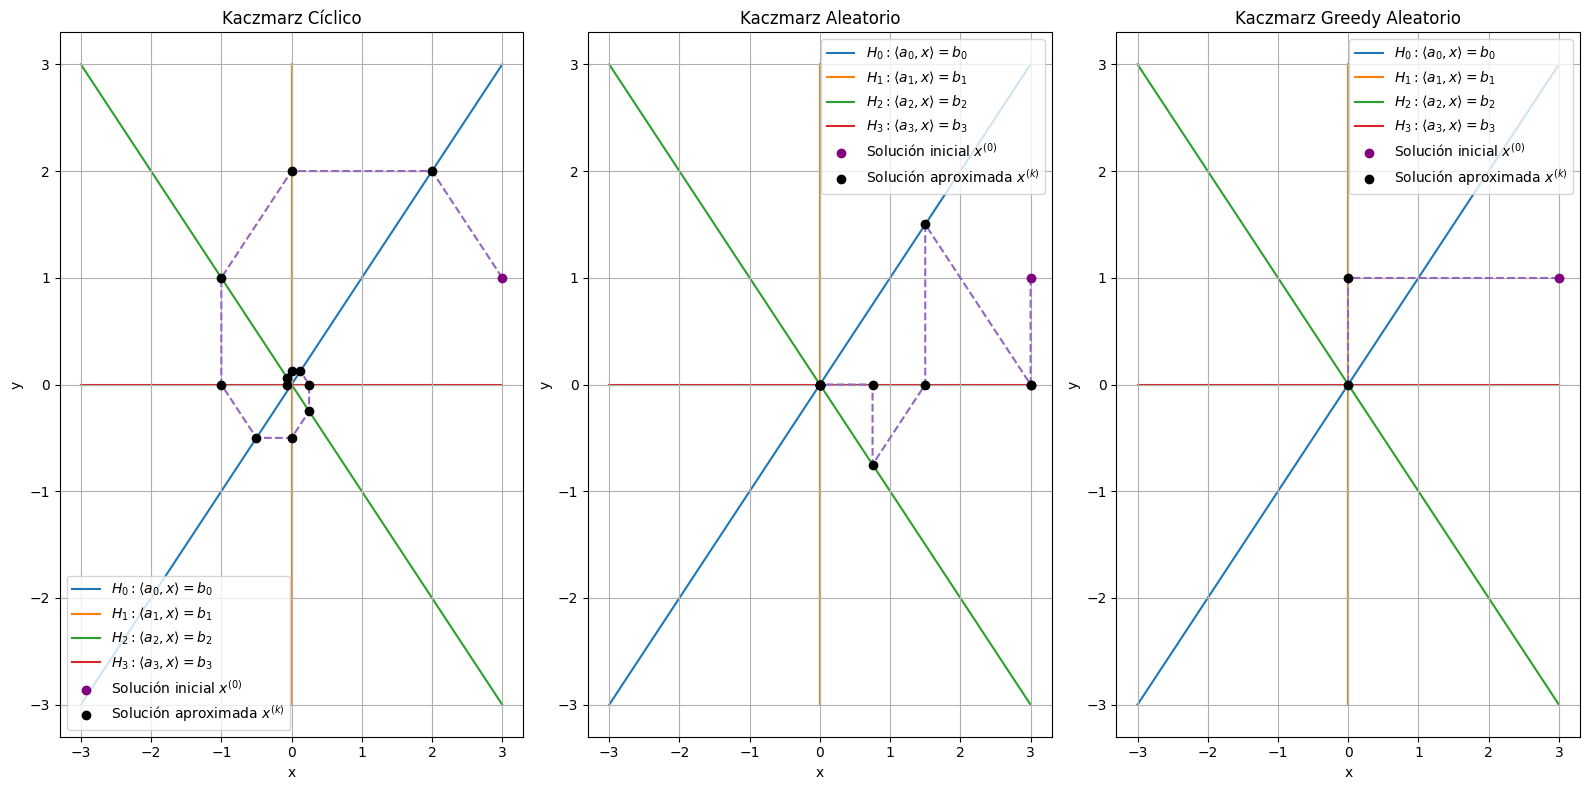

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files


def classic_kacmarz_sols(A, b, x0=None, max_iter=12, tol=1e-16):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  prev_x = torch.clone(x)

  solutions = [x0.clone()]
  for k in range(max_iter):
    i = k % m
    a_i = A[i]
    a_dot_x = torch.dot(a_i, x)
    a_dot_a = torch.sum(a_i**2)
    proyeccion = ((b[i] - a_dot_x) / a_dot_a) * a_i
    x += proyeccion
    solutions.append(x.clone())

  return solutions

def random_kacmarz_sols(A, b, x0=None, max_iter=12, tol=1e-4):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  prev_x = torch.clone(x)

  A_frob = torch.norm(A, p='fro')**2
  probs = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])

  solutions = [x0.clone()]
  for k in range(max_iter):
    i = torch.multinomial(probs, 1)[0]
    a_i = A[i]
    a_dot_x = torch.dot(a_i, x)
    a_dot_a = torch.sum(a_i**2)
    proyeccion = ((b[i] - a_dot_x) / a_dot_a) * a_i
    x += proyeccion
    solutions.append(x.clone())

  return solutions

def greedy_random_kacmarz_sols(A, b, x0=None, max_iter=30, tol=1e-4):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=A.device)
  prev_x = torch.clone(x)

  A_frob_inv = 1/(torch.norm(A, p='fro')**2)
  row_norms = torch.sum(A**2, dim=1)  # Auxiliary vector

  solutions = [x0.clone()]
  for k in range(max_iter):
    #Calculate residual
    r = b - torch.matmul(A, x)
    r_norm = torch.sum(r**2)
    r_squared = r**2

    if r_norm <= tol:
      break

    # Get epsilon
    l = r_squared / row_norms
    eps = 0.5*(1/r_norm * torch.max(l) + A_frob_inv)

    #Check if ik doesnt belong to the index set Uik
    mask = r_squared < eps * r_norm * row_norms
    r[mask] = 0

    #Compute probabilities array
    probs = (r**2) / torch.sum(r**2)

    print(probs, r_norm)

    #Project row
    i = torch.multinomial(probs, 1)[0]
    a_i = A[i]
    a_dot_x = torch.dot(a_i, x)
    a_dot_a = torch.sum(a_i**2)
    proyeccion = ((b[i] - a_dot_x) / a_dot_a) * a_i
    x += proyeccion
    solutions.append(x.clone())

  return solutions

def plot_lines(A, f):
  m, _ = A.shape  # Get the number of rows (m)

  # Extract x and y coefficients from each row of A
  x_coeffs = A[:, 0]
  y_coeffs = A[:, 1]

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  # Plot each row as a line with appropriate labels
  for i in range(m):
    a = x_coeffs[i]
    b = y_coeffs[i]
    c = f[i]

    x = np.linspace(-3, 3, 100)  # Generate x-axis values
    if b == 0:
      y = x
      x = -c / a  * np.ones_like(x) # Calculate constant y-value for vertical line
    elif a == 0:
      y = -c / b * np.ones_like(x)  # Calculate constant x-value for horizontal line
    else:
      # Calculate corresponding y-axis values using the equation
      y = (c - a * x)/b

    # Plot the line
    ax1.plot(x, y, label=f"$H_{{{i}}}: \\langle a_{{{i}}}, x \\rangle = b_{{{i}}}$", zorder=1)
    ax2.plot(x, y, label=f"$H_{{{i}}}: \\langle a_{{{i}}}, x \\rangle = b_{{{i}}}$", zorder=1)
    ax3.plot(x, y, label=f"$H_{{{i}}}: \\langle a_{{{i}}}, x \\rangle = b_{{{i}}}$", zorder=1)


  # Add labels and title
  plt.xlabel("x")
  plt.ylabel("y")

  A = torch.from_numpy(A).to(device)
  f = torch.from_numpy(f).to(device)
  A = A.float()
  x_init = torch.tensor([3, 1], dtype = torch.float)

  solutions = classic_kacmarz_sols(A, f, x_init)
  ax1.scatter(solutions[0][0], solutions[0][1], color='purple', label=r'Solución inicial $x^{(0)}$', zorder=3)
  ax1.scatter([point[0] for point in solutions[1:]], [point[1] for point in solutions[1:]], color='black', label=r'Solución aproximada $x^{(k)}$', zorder=3)
  ax1.plot([point[0] for point in solutions], [point[1] for point in solutions], linestyle="--", zorder=2)

  x_init = torch.tensor([3, 1], dtype = torch.float)
  solutions = random_kacmarz_sols(A, f, x_init)
  ax2.scatter(solutions[0][0], solutions[0][1], color='purple', label=r'Solución inicial $x^{(0)}$', zorder=3)
  ax2.scatter([point[0] for point in solutions[1:]], [point[1] for point in solutions[1:]], color='black', label=r'Solución aproximada $x^{(k)}$', zorder=3)
  ax2.plot([point[0] for point in solutions], [point[1] for point in solutions], linestyle="--", zorder=2)

  x_init = torch.tensor([3, 1], dtype = torch.float)
  print(A.shape, x_init.shape)
  solutions = greedy_random_kacmarz_sols(A, f, x_init)
  ax3.scatter(solutions[0][0], solutions[0][1], color='purple', label=r'Solución inicial $x^{(0)}$', zorder=3)
  ax3.scatter([point[0] for point in solutions[1:]], [point[1] for point in solutions[1:]], color='black', label=r'Solución aproximada $x^{(k)}$', zorder=3)
  ax3.plot([point[0] for point in solutions], [point[1] for point in solutions], linestyle="--", zorder=2)

  # Add legend
  ax1.legend()
  ax2.legend()
  ax3.legend()


  ax1.grid(True)
  ax2.grid(True)
  ax3.grid(True)

  ax1.set_title("Kaczmarz Cíclico")
  ax1.set_xlabel("x")
  ax1.set_ylabel("y")

  ax2.set_title("Kaczmarz Aleatorio")
  ax2.set_xlabel("x")
  ax2.set_ylabel("y")

  ax3.set_title("Kaczmarz Greedy Aleatorio")
  ax3.set_xlabel("x")
  ax3.set_ylabel("y")
  plt.tight_layout()
  plt.savefig("compare.png")
  files.download("compare.png")

  # Show the plot
  plt.show()

# Example usage (replace with your actual data)
A = np.array([[1, -1], [1, 0], [1, 1], [0, 1], ])
b = np.array([0, 0, 0, 0])
plot_lines(A, b)

[tensor([2., 1.]), tensor([ 2., -2.]), tensor([ 2.8000, -1.6000]), tensor([-1.6800,  0.6400]), tensor([1.0080, 1.9840]), tensor([ 1.0080, -2.0000]), tensor([ 1.0080, -2.0000]), tensor([ 1.0080, -2.0000]), tensor([ 2.6016, -1.2032]), tensor([-1.5610,  0.8781]), tensor([-1.5610,  0.8781]), tensor([-1.5610, -2.0000]), tensor([ 2.0878, -0.1756])]


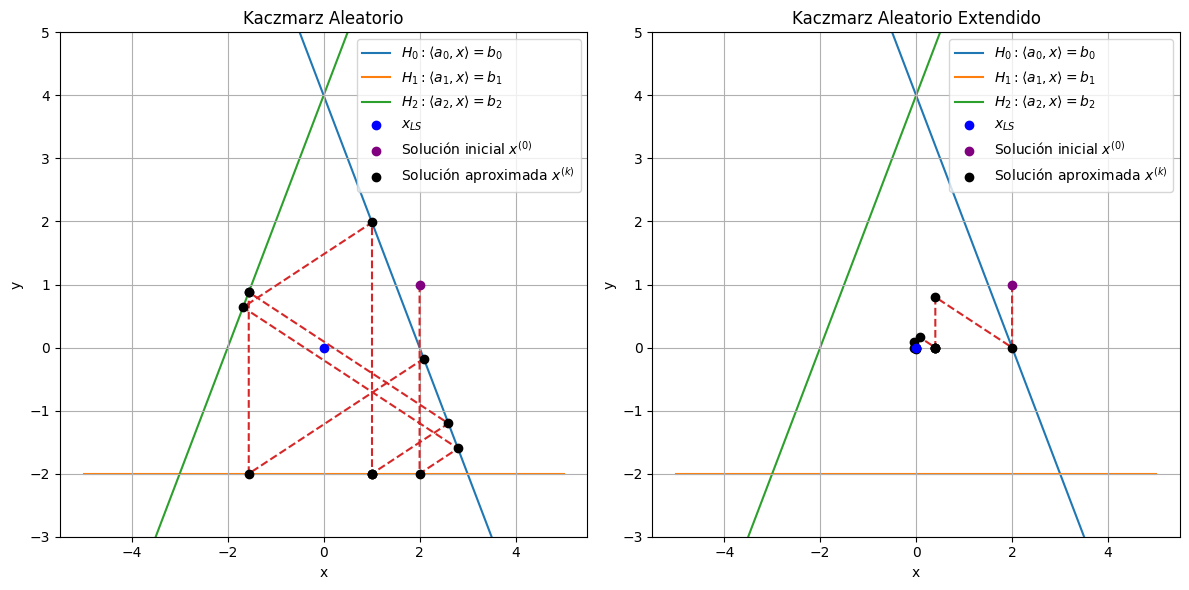

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
import torch

def random_kacmarz_sols(A, b, x0=None, max_iter=12, tol=1e-4):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=device)
  prev_x = torch.clone(x)

  A_frob = torch.norm(A, p='fro')**2
  probs = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])

  solutions = [x0.clone()]
  for k in range(max_iter):
    i = torch.multinomial(probs, 1)[0]
    a_i = A[i]
    a_dot_x = torch.dot(a_i, x)
    a_dot_a = torch.sum(a_i**2)
    proyeccion = ((b[i] - a_dot_x) / a_dot_a) * a_i
    x += proyeccion
    solutions.append(x.clone())

  return solutions

def extended_random_kacmarz_sols(A, b, x0=None, max_iter=12, tol=1e-16):
  m, d = A.shape
  x = x0 if x0 is not None else torch.zeros(d, dtype=A.dtype, device=device)
  z = b.clone()
  prev_x = torch.clone(x)

  A_frob = torch.norm(A, p='fro')**2
  probs_p = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A])
  probs_q = torch.tensor([torch.dot(ai, ai)/A_frob for ai in A.t()])

  solutions = [x0.clone()]
  for k in range(max_iter):
    i = torch.multinomial(probs_p, 1)[0]
    j = torch.multinomial(probs_q, 1)[0]

    a_i = A[i]
    a_j = A[:, j]

    z = z - (torch.dot(a_j, z)/torch.sum(a_j**2))*a_j
    x += ((b[i] - z[i] - torch.dot(a_i, x)) /torch.sum(a_i**2)) * a_i
    solutions.append(x.clone())

  return solutions

def plot_lines(A, f):
  m, _ = A.shape  # Get the number of rows (m)

  A_T = A.T  # Transpose of A
  ATA = A_T.dot(A)  # Matrix multiplication A^T * A
  ATb = A_T.dot(f)  # Matrix multiplication A^T * b
  x_ls = np.linalg.solve(ATA, ATb)

  # Extract x and y coefficients from each row of A
  x_coeffs = A[:, 0]
  y_coeffs = A[:, 1]

  fig, (ax1, ax2) = plt.subplots(1, 2)

  # Plot each row as a line with appropriate labels
  for i in range(m):
    a = x_coeffs[i]
    b = y_coeffs[i]
    c = f[i]

    x = np.linspace(-5, 5, 100)  # Generate x-axis values
    if b == 0:
      y = x
      x = -c / a  * np.ones_like(x) # Calculate constant y-value for vertical line
    elif a == 0:
      y = c / b * np.ones_like(x)  # Calculate constant x-value for horizontal line
    else:
      # Calculate corresponding y-axis values using the equation
      y = (c - a * x)/b

    # Plot the line
    ax1.plot(x, y, label=f"$H_{{{i}}}: \\langle a_{{{i}}}, x \\rangle = b_{{{i}}}$", zorder=1)
    ax2.plot(x, y, label=f"$H_{{{i}}}: \\langle a_{{{i}}}, x \\rangle = b_{{{i}}}$", zorder=1)


  # Add labels and title
  plt.xlabel("x")
  plt.ylabel("y")

  A = torch.from_numpy(A).to(device)
  f = torch.from_numpy(f).to(device)
  A = A.float()
  f = f.float()
  x_init = torch.tensor([2, 1], dtype = torch.float)

  solutions = random_kacmarz_sols(A, f, x_init)
  print(solutions)
  ax1.scatter(x_ls[0], x_ls[1], color='blue', label=r'$x_{LS}$', zorder=4)
  ax1.scatter(solutions[0][0], solutions[0][1], color='purple', label=r'Solución inicial $x^{(0)}$', zorder=3)
  ax1.scatter([point[0] for point in solutions[1:]], [point[1] for point in solutions[1:]], color='black', label=r'Solución aproximada $x^{(k)}$', zorder=3)
  ax1.plot([point[0] for point in solutions], [point[1] for point in solutions], linestyle="--", zorder=2)
  ax1.set_ylim(-3, 5)

  x_init = torch.tensor([2, 1], dtype = torch.float)
  solutions = extended_random_kacmarz_sols(A, f, x_init)
  ax2.scatter(x_ls[0], x_ls[1], color='blue', label=r'$x_{LS}$', zorder=4)
  ax2.scatter(solutions[0][0], solutions[0][1], color='purple', label=r'Solución inicial $x^{(0)}$', zorder=3)
  ax2.scatter([point[0] for point in solutions[1:]], [point[1] for point in solutions[1:]], color='black', label=r'Solución aproximada $x^{(k)}$', zorder=3)
  ax2.plot([point[0] for point in solutions], [point[1] for point in solutions], linestyle="--", zorder=2)
  ax2.set_ylim(-3, 5)

  # Add legend
  ax1.legend()
  ax2.legend()

  ax1.grid(True)
  ax2.grid(True)

  ax1.set_title("Kaczmarz Aleatorio")
  ax1.set_xlabel("x")
  ax1.set_ylabel("y")

  ax2.set_title("Kaczmarz Aleatorio Extendido")
  ax2.set_xlabel("x")
  ax2.set_ylabel("y")

  plt.tight_layout()

  # Show the plot
  plt.show()

# Example usage (replace with your actual data)
A = np.array([[1, 0.5], [0, 1], [-1, 0.5], ])
b = np.array([2, -2, 2])
plot_lines(A, b)
